In [1]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.utils.data import DataLoader
from torchvision import transforms
import torch
import matplotlib.pyplot as plt

import os
import pandas as pd
import skimage.io
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image



%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
def fetch_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      dx=80,dy=80,
                      dimx=64,dimy=64
    ):

    #download if not exists
    if not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s" % attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,) 
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])


    #read photos
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(images_name):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)
    # print(photo_ids)
    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    # print(df.shape)
    #image preprocessing
    all_photos =df['photo_path'].apply(skimage.io.imread)\
                                .apply(lambda img:img[dy:-dy,dx:-dx])\
                                .apply(lambda img: resize(img,[dimx,dimy]))

    all_photos = np.stack(all_photos.values)#.astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)
    
    return all_photos, all_attrs

In [4]:
# The following line fetches you two datasets: images, usable for autoencoder training and attributes.
# Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind


data, attrs = fetch_dataset()

images not found, donwloading...
extracting...
done
attributes not found, downloading...
done


In [5]:
attrs.head()

,Male,Asian,White,Black,Baby,Child,Youth,Middle Aged,Senior,Black Hair,...,Pale Skin,5 o' Clock Shadow,Strong Nose-Mouth Lines,Wearing Lipstick,Flushed Face,High Cheekbones,Brown Eyes,Wearing Earrings,Wearing Necktie,Wearing Necklace
0,1.568346,-1.889043,1.737203,-0.929729,-1.471799,-0.19558,-0.835609,-0.351468,-1.012533,-0.719593,...,0.361738,1.166118,-1.164916,-1.13999,-2.371746,-1.299932,-0.414682,-1.144902,0.694007,-0.826609
1,0.169851,-0.982408,0.422709,-1.282184,-1.36006,-0.867002,-0.452293,-0.197521,-0.956073,-0.802107,...,-0.832036,-0.39768,0.87416,-0.945431,-0.268649,-0.006244,-0.030406,-0.480128,0.66676,-0.496559
2,0.997749,-1.364195,-0.157377,-0.756447,-1.891825,-0.871526,-0.862893,0.031445,-1.341523,-0.090037,...,1.549743,1.884745,-0.999765,-1.359858,-1.912108,-1.095634,0.915126,-0.572332,0.144262,-0.841231
3,1.122719,-1.997799,1.916144,-2.514214,-2.580071,-1.404239,0.057551,0.000196,-1.273512,-1.431462,...,0.567822,-0.176089,1.108125,-1.600944,-3.264613,0.813418,0.308631,-0.848693,0.475941,-0.447025
4,1.078214,-2.008098,1.676211,-2.278056,-2.651845,-1.348408,0.649089,0.017656,-1.889111,-1.857213,...,-1.461474,-0.955283,0.119113,-1.128176,-3.161048,0.08268,-0.439614,-0.359859,-0.760774,-0.410152


In [6]:
IMAGEX = 64
IMAGEY = 64

# data_resize = list(map(lambda x: skimage.transform.resize(x, (IMAGEY, IMAGEX)), data))
data_trans = list(map(lambda x: x.transpose(2, 0, 1), data))
data_torch = torch.FloatTensor(data_trans)
trainset, valset = train_test_split(data_torch, train_size = 0.9)

dataloader = {
    'train': DataLoader(trainset, batch_size=32, shuffle=True, drop_last=True),
    'valid': DataLoader(valset, batch_size=32),
}

<ipython-input-6-795d7ebeb5e5>:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  data_torch = torch.FloatTensor(data_trans)


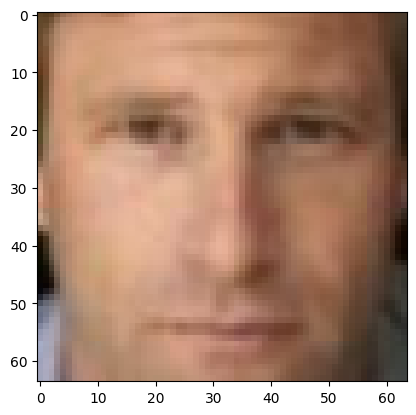

In [7]:
plt.imshow(data_torch[0].numpy().transpose(1,2,0))

In [8]:
class Autoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=2, padding=1),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=2, padding=1),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=2, padding=1),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Dropout(0.5),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3, 3), stride=2, padding=1),

            nn.Conv2d(in_channels=128, out_channels=16, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            
            nn.Flatten(),
        )
        # 16 x 4 x 4
        self.decoder = nn.Sequential(
            nn.Unflatten(-1, (16, 4, 4)),
            
            nn.Conv2d(in_channels=16, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=32, out_channels=3, kernel_size=(3, 3), padding=1),
            nn.Sigmoid(),
        )
        
    def forward(self, sample):
        latent = self.encoder(sample)
        reconstructed = self.decoder(latent)
        return reconstructed, latent
    
    def latent(self, sample):
        latent = self.encoder(sample)
        return latent
    
    def sample(self, z):
        generated = self.decoder(z)
        return generated

In [9]:
criterion = nn.MSELoss()
autoencoder = Autoencoder().to(device)
optimizer = torch.optim.Adam(autoencoder.parameters())

In [10]:
# <тут Ваш код тренировки автоэнкодера>

def train(model,optimizer,criterion,train_data,val_data, epochs = 20, device = torch.device('cpu')):
  val_batch = next(iter(val_data))

  train_losses = []
  val_losses = []
  progress = tqdm(range(epochs), desc='Epoch')
  for epoch in progress:
    for batch in train_data:
      batch = batch.to(device)
      # print(batch.shape)
      model.train()
      optimizer.zero_grad()
      
      reconstruction, latent_vector = model(batch)
      loss = criterion(batch, reconstruction)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      
    with torch.no_grad():
      model.eval()
      val_reconstruction, val_latent_vector = model(val_batch.to(device))
      # val_imgs.append(reconstruction)
      loss = criterion(val_batch.to(device),val_reconstruction)
      # print(loss)
      val_losses.append(loss.cpu())
      
    print('\n',"train loss:", train_losses[-1].cpu().detach().numpy(),' valid loss:', val_losses[-1].cpu().detach().numpy())

  # return train_losses, val_losses

In [11]:
train(autoencoder,optimizer, criterion, dataloader['train'], dataloader['valid'], device = device)

Epoch:   5%|▌         | 1/20 [00:12<03:49, 12.10s/it]


 train loss: 0.0069109085  valid loss: 0.006883714


Epoch:  10%|█         | 2/20 [00:17<02:25,  8.10s/it]


 train loss: 0.006679817  valid loss: 0.0056034504


Epoch:  15%|█▌        | 3/20 [00:22<01:56,  6.84s/it]


 train loss: 0.0072925217  valid loss: 0.0047559957


Epoch:  20%|██        | 4/20 [00:28<01:40,  6.27s/it]


 train loss: 0.005497733  valid loss: 0.0039649117


Epoch:  25%|██▌       | 5/20 [00:33<01:29,  5.96s/it]


 train loss: 0.0051606023  valid loss: 0.0042572515


Epoch:  30%|███       | 6/20 [00:39<01:21,  5.79s/it]


 train loss: 0.0051108412  valid loss: 0.0036097548


Epoch:  35%|███▌      | 7/20 [00:45<01:16,  5.88s/it]


 train loss: 0.0039069112  valid loss: 0.0033649877


Epoch:  40%|████      | 8/20 [00:50<01:09,  5.78s/it]


 train loss: 0.004237387  valid loss: 0.0036181123


Epoch:  45%|████▌     | 9/20 [00:56<01:02,  5.72s/it]


 train loss: 0.0040347115  valid loss: 0.0031175667


Epoch:  50%|█████     | 10/20 [01:01<00:56,  5.67s/it]


 train loss: 0.0035490845  valid loss: 0.0035367124


Epoch:  55%|█████▌    | 11/20 [01:07<00:50,  5.63s/it]


 train loss: 0.0040102093  valid loss: 0.0030175128


Epoch:  60%|██████    | 12/20 [01:12<00:44,  5.58s/it]


 train loss: 0.0037741214  valid loss: 0.0028614819


Epoch:  65%|██████▌   | 13/20 [01:18<00:38,  5.54s/it]


 train loss: 0.002757539  valid loss: 0.0027914625


Epoch:  70%|███████   | 14/20 [01:23<00:33,  5.50s/it]


 train loss: 0.0025457824  valid loss: 0.003153215


Epoch:  75%|███████▌  | 15/20 [01:29<00:27,  5.48s/it]


 train loss: 0.0029348056  valid loss: 0.0025997967


Epoch:  80%|████████  | 16/20 [01:34<00:21,  5.45s/it]


 train loss: 0.0024550203  valid loss: 0.0024648895


Epoch:  85%|████████▌ | 17/20 [01:39<00:16,  5.43s/it]


 train loss: 0.0032089246  valid loss: 0.0028032386


Epoch:  90%|█████████ | 18/20 [01:45<00:10,  5.42s/it]


 train loss: 0.0030553143  valid loss: 0.0027294194


Epoch:  95%|█████████▌| 19/20 [01:50<00:05,  5.41s/it]


 train loss: 0.0038053454  valid loss: 0.0030394306


Epoch: 100%|██████████| 20/20 [01:56<00:00,  5.80s/it]


 train loss: 0.0034794472  valid loss: 0.002369184


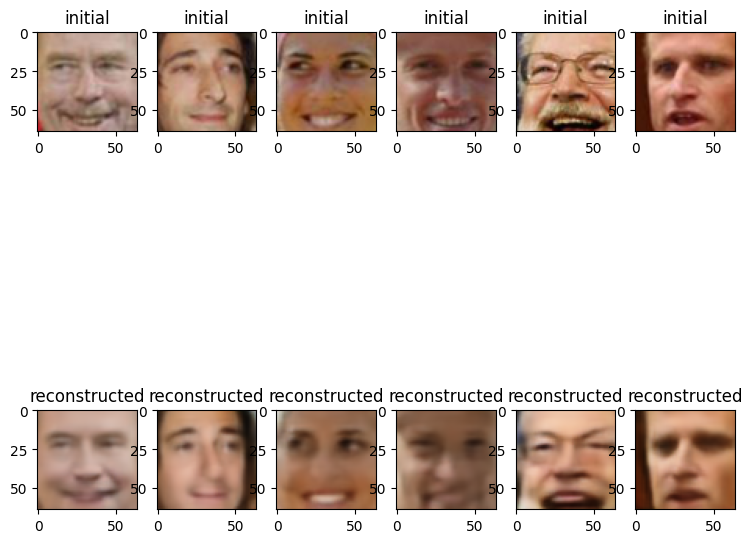

In [12]:
# < тут Ваш код: выведите первые Х картинок и их реконструкций из val выборки на экран>
fig = plt.figure(figsize=(9, 9))
axes = fig.subplots(nrows=2, ncols=6)

batch = next(iter(dataloader['valid']))
reconstructions, latent_vecs = autoencoder(batch.to(device))

for i in range(len(valset[:6])):
  axes[0, i].imshow(valset[i].cpu().numpy().transpose(1,2,0))
  axes[0, i].set_title('initial')

  img_recon = reconstructions[i] 
  axes[1, i].imshow(img_recon.cpu().detach().numpy().transpose(1,2,0))
  axes[1, i].set_title('reconstructed')

In [13]:
latents = torch.Tensor()
for inputs in tqdm(dataloader['train']):
    inputs = inputs.to(device)
    with torch.no_grad():
        latent = autoencoder.latent(inputs).cpu()
        latents = torch.cat((latents, latent))
latents.shape

100%|██████████| 369/369 [00:01<00:00, 249.07it/s]


torch.Size([11808, 256])

In [14]:
lat_mean = latents.mean(dim=0)
lat_std = latents.std(dim=0)
lat_mean.shape, lat_std.shape

(torch.Size([256]), torch.Size([256]))

In [15]:
# сгенерируем 32 рандомных векторов размера latent_space
z = torch.FloatTensor(np.random.randn(25, 256))
z = z * lat_std/2 + lat_mean
output = autoencoder.sample(z.to(device)).cpu().detach()

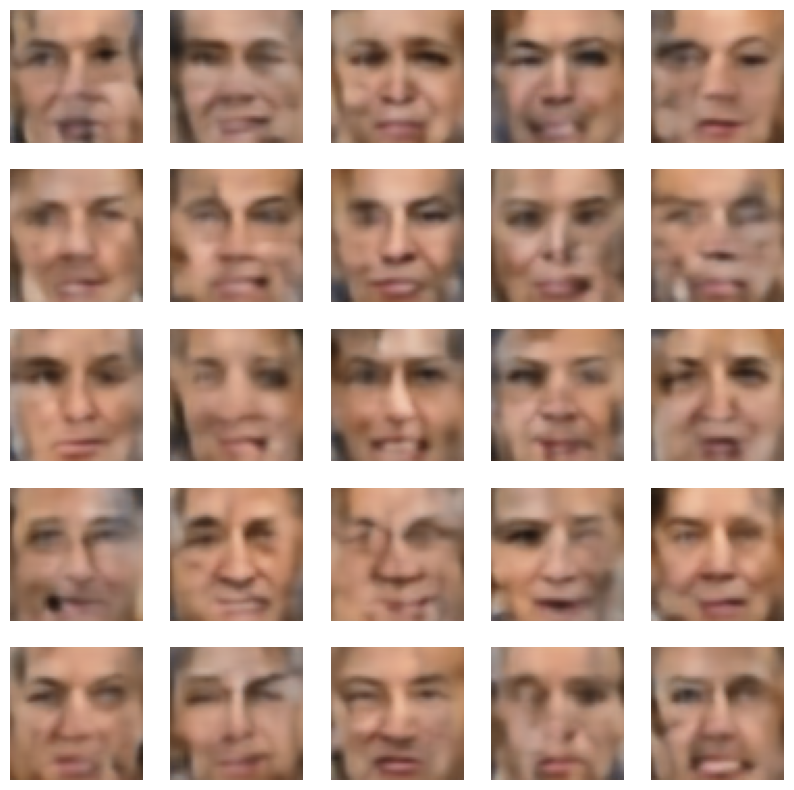

In [16]:
rows, cols = (5, 5)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
for ax, img in zip(axes.flatten(), output):
    ax.axis('off')
    ax.imshow(img.numpy().transpose(1, 2, 0))

In [17]:
smile = [171, 308, 1433, 1984, 2593, 2816, 3722, 3843, 4623, 4810, 5046, 5071, 5448, 5497, 5619, 6220, 6468, 6842]
non_smile = [170, 307, 1432, 1983, 2594, 2815, 3721, 3844, 4622, 4809, 5047, 5072, 5447, 5496, 5620, 6221, 6467, 6843]
input_smile = torch.FloatTensor(data_torch[smile])
input_non_smile = torch.FloatTensor(data_torch[non_smile])

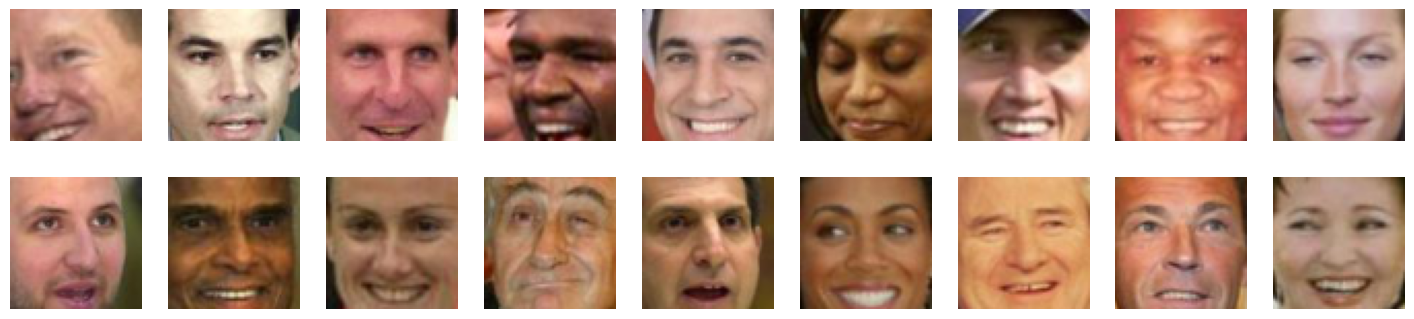

In [18]:
#smiling
rows, cols = (2,9)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
for ax, img in zip(axes.flatten(), input_smile):
    ax.axis('off')
    ax.imshow(img.numpy().transpose(1, 2, 0))

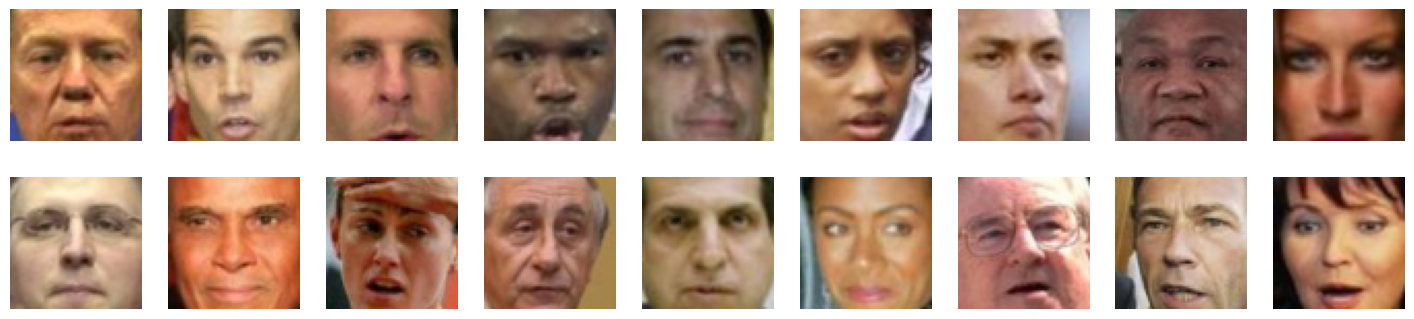

In [19]:
#non smiling
rows, cols = (2,9)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
for ax, img in zip(axes.flatten(), input_non_smile):
    ax.axis('off')
    ax.imshow(img.numpy().transpose(1, 2, 0))

In [20]:
input_smile = input_smile.to(device)
input_non_smile = input_non_smile.to(device)
autoencoder.eval()
with torch.no_grad():
    latent_smile = autoencoder.latent(input_smile).cpu()
    latent_non_smile = autoencoder.latent(input_non_smile).cpu()

In [21]:
smile = latent_smile.mean(dim = 0) - latent_non_smile.mean(dim = 0)

In [22]:
sad_faces = [0, 2, 12, 16, 21, 2112, 2120, 2116]
sad_faces = torch.Tensor(data_torch[sad_faces])
sad_faces = sad_faces.to(device)
autoencoder.eval()
with torch.no_grad():
    latent_sad = autoencoder.latent(sad_faces).cpu()
    latent_sad_to_smile = (latent_sad + smile).to(device)
    smile_faces = autoencoder.sample(latent_sad_to_smile)
faces = torch.cat((sad_faces.cpu(), smile_faces.cpu()))

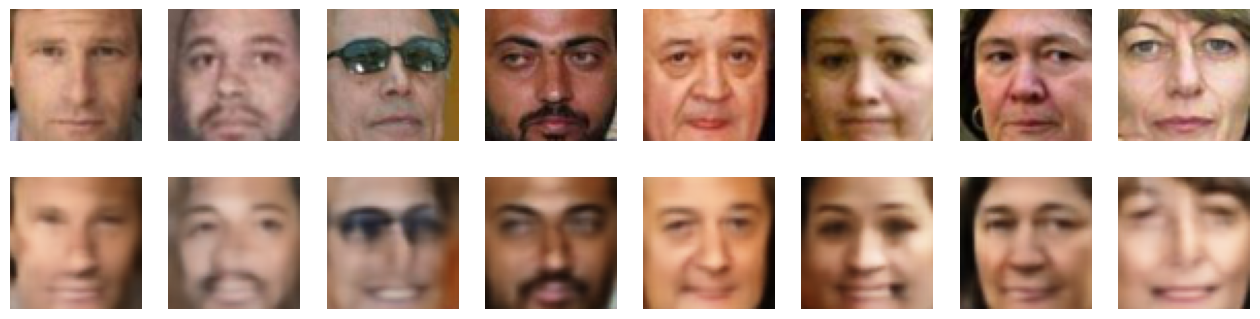

In [23]:
rows, cols = (2,8)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
for ax, img in zip(axes.flatten(), faces):
    ax.axis('off')
    ax.imshow(img.numpy().transpose(1, 2, 0))

#  Variational Autoencoder

In [24]:
batch_size = 32
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_nums = list(map(lambda x: x[0].to(device),train_dataset))
test_nums = list(map(lambda x: x[0].to(device),test_dataset))

train_loader = torch.utils.data.DataLoader(dataset=torch.stack(train_nums),
                                           batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=torch.stack(test_nums),
                                          batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 77636150.37it/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 24343989.92it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 24942264.73it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 22074772.62it/s]


Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [25]:
class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        # <определите архитектуры encoder и decoder
        # помните, у encoder должны быть два "хвоста", 
        # т.е. encoder должен кодировать картинку в 2 переменные -- mu и logsigma>

        #encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=2, padding=1),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=2, padding=1),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=2, padding=1),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Dropout(0.5),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3, 3), stride=2, padding=1),

            nn.Conv2d(in_channels=128, out_channels=64*2, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            
            nn.Flatten(),
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.Unflatten(-1, (16, 4, 4)),
            
            nn.Conv2d(in_channels=16, out_channels=128, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=32, out_channels=1, kernel_size=(3, 3), padding=1),
            nn.Sigmoid(),
#             nn.Upsample(scale_factor=2),
#             nn.Conv2d(in_channels=32, out_channels=1, kernel_size=(3, 3), padding=1),
#             nn.Sigmoid(),
        )

    def encode(self, x):
        # <реализуйте forward проход энкодера
        # в качестве ваозвращаемых переменных -- mu и logsigma>
#         print("latent", self.encoder(x).view(-1,2,64).shape)
        # (32, 128)
        latent = self.encoder(x).view(-1, 2, 256)

        mu = latent[:,0,:] # the first feature values as mean
        logsigma = latent[:,1,:] # the other feature values as variance
#         print('mu', mu.shape)
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            # <засемплируйте латентный вектор из нормального распределения с параметрами mu и sigma>
            std = torch.exp(0.5 * logsigma) # standard deviation
            eps = torch.randn_like(std) # `randn_like` as we need the same size
            sample = mu + (eps * std) # sampling as if coming from the input space
            return sample
        else:
            # на инференсе возвращаем не случайный вектор из нормального распределения, а центральный -- mu. 
            # на инференсе выход автоэнкодера должен быть детерминирован.
            return mu
    
    def decode(self, z):
        # <реализуйте forward проход декодера
        # в качестве возвращаемой переменной -- reconstruction>
        reconstruction = self.decoder(z)
        
        return reconstruction

    def forward(self, x):
        # <используя encode и decode, реализуйте forward проход автоэнкодера
        # в качестве ваозвращаемых переменных -- mu, logsigma и reconstruction>
        mu, logsigma = self.encode(x) # the other feature values as variance
        z = self.gaussian_sampler(mu, logsigma)
#         print('z', z.shape)

        reconstruction = self.decode(z)

        return mu, logsigma, reconstruction

In [26]:
class KLDivergenceLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, mu, logsigma):
        return -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())


class VAELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.kl_divergence = KLDivergenceLoss()
        self.log_likelihood = nn.BCELoss(reduction='sum')

    def forward(self,x, mu, logsigma, reconstruction ):
        return self.kl_divergence(mu, logsigma) + self.log_likelihood(reconstruction, x)

In [27]:
criterion = VAELoss()

vae = VAE().to(device)

optimizer = torch.optim.Adam(vae.parameters())

In [28]:
device = 'cuda'
def train(model,optimizer,criterion,train_data,val_data, epochs = 70, device = torch.device('cpu')):
  val_batch = next(iter(val_data)).to(device)

  train_losses = []
  val_losses = []
  progress = tqdm(range(epochs), desc='Epoch')
  for epoch in progress:
    for batch in train_data:
      batch = batch.to(device)
#       print(batch.shape)
      model.train()
      optimizer.zero_grad()
      
      mu, logsigma, reconstruction = model(batch.cuda())
#       print(reconstruction.shape)
      loss = criterion(batch.cuda(), mu, logsigma, reconstruction)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      
    with torch.no_grad():
      model.eval()
      val_mu, val_logsigma, val_reconstruction = model(val_batch.cuda())
      # val_imgs.append(reconstruction)
      loss = criterion(val_batch.cuda(), val_mu, val_logsigma, val_reconstruction)
      # print(loss)
      val_losses.append(loss.cpu())
      
    print('\n',"train loss:", train_losses[-1].cpu().detach().numpy(),' valid loss:', val_losses[-1].cpu().detach().numpy())

  # return train_losses, val_losses

In [29]:
train(vae, optimizer, criterion, train_loader, test_loader)

Epoch:   1%|▏         | 1/70 [00:13<15:07, 13.16s/it]


 train loss: 5893.2695  valid loss: 5059.633


Epoch:   3%|▎         | 2/70 [00:25<14:26, 12.75s/it]


 train loss: 5612.076  valid loss: 4746.174


Epoch:   4%|▍         | 3/70 [00:37<13:57, 12.51s/it]


 train loss: 5384.4473  valid loss: 4645.1626


Epoch:   6%|▌         | 4/70 [00:49<13:31, 12.30s/it]


 train loss: 5036.825  valid loss: 4505.08


Epoch:   7%|▋         | 5/70 [01:01<13:07, 12.12s/it]


 train loss: 5066.1074  valid loss: 4603.6094


Epoch:   9%|▊         | 6/70 [01:13<12:51, 12.05s/it]


 train loss: 5123.672  valid loss: 4767.5146


Epoch:  10%|█         | 7/70 [01:25<12:38, 12.04s/it]


 train loss: 5025.138  valid loss: 4853.5605


Epoch:  11%|█▏        | 8/70 [01:37<12:31, 12.13s/it]


 train loss: 5023.142  valid loss: 4962.4956


Epoch:  13%|█▎        | 9/70 [01:49<12:19, 12.12s/it]


 train loss: 4936.1914  valid loss: 5001.813


Epoch:  14%|█▍        | 10/70 [02:02<12:18, 12.31s/it]


 train loss: 4956.2437  valid loss: 4777.387


Epoch:  16%|█▌        | 11/70 [02:14<12:00, 12.21s/it]


 train loss: 4974.1826  valid loss: 5108.893


Epoch:  17%|█▋        | 12/70 [02:26<11:43, 12.13s/it]


 train loss: 4825.466  valid loss: 4890.373


Epoch:  19%|█▊        | 13/70 [02:38<11:29, 12.10s/it]


 train loss: 4817.09  valid loss: 5012.1157


Epoch:  20%|██        | 14/70 [02:50<11:17, 12.10s/it]


 train loss: 4968.9824  valid loss: 5023.0977


Epoch:  21%|██▏       | 15/70 [03:02<11:06, 12.11s/it]


 train loss: 4892.125  valid loss: 4977.545


Epoch:  23%|██▎       | 16/70 [03:15<10:54, 12.12s/it]


 train loss: 4736.42  valid loss: 5167.841


Epoch:  24%|██▍       | 17/70 [03:27<10:41, 12.10s/it]


 train loss: 4844.6494  valid loss: 5236.375


Epoch:  26%|██▌       | 18/70 [03:39<10:29, 12.10s/it]


 train loss: 4865.1763  valid loss: 5218.2534


Epoch:  27%|██▋       | 19/70 [03:51<10:17, 12.11s/it]


 train loss: 4646.63  valid loss: 5310.2446


Epoch:  29%|██▊       | 20/70 [04:03<10:06, 12.12s/it]


 train loss: 4868.0117  valid loss: 5380.943


Epoch:  30%|███       | 21/70 [04:15<09:54, 12.13s/it]


 train loss: 4896.038  valid loss: 5078.614


Epoch:  31%|███▏      | 22/70 [04:27<09:42, 12.13s/it]


 train loss: 4697.3843  valid loss: 5356.4854


Epoch:  33%|███▎      | 23/70 [04:39<09:31, 12.16s/it]


 train loss: 4761.0547  valid loss: 5192.6016


Epoch:  34%|███▍      | 24/70 [04:52<09:18, 12.15s/it]


 train loss: 4758.3384  valid loss: 5375.5093


Epoch:  36%|███▌      | 25/70 [05:04<09:06, 12.14s/it]


 train loss: 4763.5874  valid loss: 5324.2026


Epoch:  37%|███▋      | 26/70 [05:16<08:52, 12.10s/it]


 train loss: 4729.9155  valid loss: 5347.0674


Epoch:  39%|███▊      | 27/70 [05:28<08:40, 12.11s/it]


 train loss: 4694.412  valid loss: 5182.449


Epoch:  40%|████      | 28/70 [05:40<08:31, 12.18s/it]


 train loss: 4857.699  valid loss: 5448.805


Epoch:  41%|████▏     | 29/70 [05:52<08:18, 12.16s/it]


 train loss: 4793.602  valid loss: 5474.2617


Epoch:  43%|████▎     | 30/70 [06:05<08:07, 12.19s/it]


 train loss: 4676.5835  valid loss: 5261.474


Epoch:  44%|████▍     | 31/70 [06:17<07:55, 12.18s/it]


 train loss: 4776.867  valid loss: 5390.887


Epoch:  46%|████▌     | 32/70 [06:29<07:43, 12.19s/it]


 train loss: 4659.247  valid loss: 5521.963


Epoch:  47%|████▋     | 33/70 [06:41<07:30, 12.19s/it]


 train loss: 4745.2554  valid loss: 5417.774


Epoch:  49%|████▊     | 34/70 [06:53<07:19, 12.21s/it]


 train loss: 4630.3306  valid loss: 5420.223


Epoch:  50%|█████     | 35/70 [07:06<07:07, 12.21s/it]


 train loss: 4706.8765  valid loss: 5490.4805


Epoch:  51%|█████▏    | 36/70 [07:19<07:02, 12.42s/it]


 train loss: 4691.181  valid loss: 5500.293


Epoch:  53%|█████▎    | 37/70 [07:31<06:53, 12.54s/it]


 train loss: 4645.1387  valid loss: 5550.4053


Epoch:  54%|█████▍    | 38/70 [07:45<06:48, 12.76s/it]


 train loss: 4769.7676  valid loss: 5914.839


Epoch:  56%|█████▌    | 39/70 [07:57<06:35, 12.75s/it]


 train loss: 4625.213  valid loss: 5758.2944


Epoch:  57%|█████▋    | 40/70 [08:10<06:18, 12.62s/it]


 train loss: 4730.8057  valid loss: 5633.35


Epoch:  59%|█████▊    | 41/70 [08:22<06:02, 12.51s/it]


 train loss: 4863.481  valid loss: 5366.4976


Epoch:  60%|██████    | 42/70 [08:34<05:49, 12.46s/it]


 train loss: 4680.372  valid loss: 5593.5806


Epoch:  61%|██████▏   | 43/70 [08:47<05:35, 12.41s/it]


 train loss: 4950.0825  valid loss: 5611.661


Epoch:  63%|██████▎   | 44/70 [08:59<05:21, 12.38s/it]


 train loss: 4659.9756  valid loss: 5558.1465


Epoch:  64%|██████▍   | 45/70 [09:11<05:09, 12.38s/it]


 train loss: 4706.024  valid loss: 5675.193


Epoch:  66%|██████▌   | 46/70 [09:24<04:58, 12.42s/it]


 train loss: 4750.479  valid loss: 5347.761


Epoch:  67%|██████▋   | 47/70 [09:36<04:44, 12.35s/it]


 train loss: 4700.2285  valid loss: 5842.034


Epoch:  69%|██████▊   | 48/70 [09:48<04:30, 12.32s/it]


 train loss: 4638.198  valid loss: 5703.997


Epoch:  70%|███████   | 49/70 [10:01<04:19, 12.34s/it]


 train loss: 4709.418  valid loss: 5887.881


Epoch:  71%|███████▏  | 50/70 [10:13<04:05, 12.28s/it]


 train loss: 4761.027  valid loss: 5523.098


Epoch:  73%|███████▎  | 51/70 [10:25<03:53, 12.27s/it]


 train loss: 4794.7363  valid loss: 5485.6963


Epoch:  74%|███████▍  | 52/70 [10:37<03:41, 12.30s/it]


 train loss: 4428.4487  valid loss: 5617.395


Epoch:  76%|███████▌  | 53/70 [10:50<03:29, 12.30s/it]


 train loss: 4792.305  valid loss: 5459.018


Epoch:  77%|███████▋  | 54/70 [11:02<03:16, 12.29s/it]


 train loss: 4785.3623  valid loss: 5358.984


Epoch:  79%|███████▊  | 55/70 [11:14<03:04, 12.29s/it]


 train loss: 4751.01  valid loss: 5441.7954


Epoch:  80%|████████  | 56/70 [11:27<02:52, 12.30s/it]


 train loss: 4702.712  valid loss: 5879.244


Epoch:  81%|████████▏ | 57/70 [11:39<02:39, 12.26s/it]


 train loss: 4550.9883  valid loss: 5377.1675


Epoch:  83%|████████▎ | 58/70 [11:51<02:27, 12.25s/it]


 train loss: 4600.9385  valid loss: 5751.7593


Epoch:  84%|████████▍ | 59/70 [12:03<02:14, 12.26s/it]


 train loss: 4706.4287  valid loss: 5564.2534


Epoch:  86%|████████▌ | 60/70 [12:16<02:02, 12.30s/it]


 train loss: 4586.5815  valid loss: 5539.039


Epoch:  87%|████████▋ | 61/70 [12:28<01:51, 12.38s/it]


 train loss: 4619.235  valid loss: 5556.6514


Epoch:  89%|████████▊ | 62/70 [12:41<01:39, 12.44s/it]


 train loss: 4682.0195  valid loss: 5466.142


Epoch:  90%|█████████ | 63/70 [12:53<01:27, 12.43s/it]


 train loss: 4727.041  valid loss: 5732.117


Epoch:  91%|█████████▏| 64/70 [13:06<01:14, 12.50s/it]


 train loss: 4647.658  valid loss: 5580.2715


Epoch:  93%|█████████▎| 65/70 [13:18<01:02, 12.51s/it]


 train loss: 4708.6016  valid loss: 5568.7637


Epoch:  94%|█████████▍| 66/70 [13:31<00:50, 12.52s/it]


 train loss: 4634.6724  valid loss: 5580.5195


Epoch:  96%|█████████▌| 67/70 [13:43<00:37, 12.50s/it]


 train loss: 4618.9062  valid loss: 5675.6997


Epoch:  97%|█████████▋| 68/70 [13:56<00:25, 12.51s/it]


 train loss: 4795.015  valid loss: 5599.8735


Epoch:  99%|█████████▊| 69/70 [14:08<00:12, 12.53s/it]


 train loss: 4634.381  valid loss: 5407.0327


Epoch: 100%|██████████| 70/70 [14:21<00:00, 12.31s/it]


 train loss: 4608.622  valid loss: 5696.7905


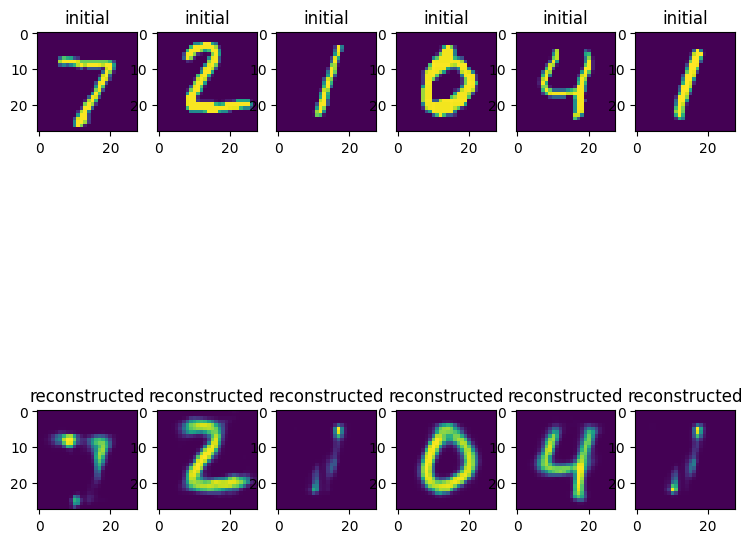

In [30]:
fig = plt.figure(figsize=(9, 9))
axes = fig.subplots(nrows=2, ncols=6)

batch = next(iter(test_loader))
_,_,reconstructions= vae(batch.to(device))

for i in range(len(test_nums[:6])):
  axes[0, i].imshow(test_nums[i].cpu().numpy().transpose(1,2,0))
  axes[0, i].set_title('initial')

  img_recon = reconstructions[i] 
  axes[1, i].imshow(img_recon.cpu().detach().numpy().transpose(1,2,0))
  axes[1, i].set_title('reconstructed')

In [31]:
latents = torch.Tensor()
for inputs in tqdm(train_loader):
    inputs = inputs.to(device)
    with torch.no_grad():
        mu, logsigma = vae.encode(inputs)
        z = vae.gaussian_sampler(mu, logsigma)
        latents = torch.cat((latents.cpu(), z.cpu()))

lat_mean = latents.mean(dim=0)
lat_std = latents.std(dim=0)


100%|██████████| 1875/1875 [00:12<00:00, 146.57it/s]


In [32]:
z = torch.FloatTensor([np.random.normal(0, 1, 256) for i in range(10)])
z = z * lat_std + lat_mean

vae.eval()
with torch.no_grad():
    sample = vae.decode(z.to(device))
sample = sample.cpu().detach()

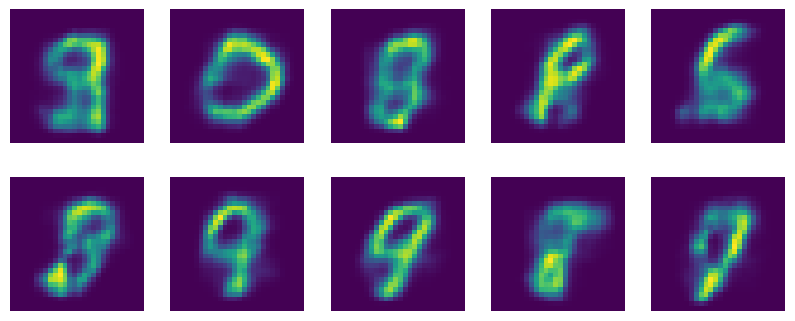

In [33]:
rows, cols = (2, 5)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
for ax, img in zip(axes.flatten(), sample):
    ax.axis('off')
    ax.imshow(img.numpy().transpose(1, 2, 0))

In [34]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.patheffects as PathEffects

In [35]:
# <ваш код получения латентных представлений, применения TSNE и визуализации>
x = latents[::5].numpy()
colors = np.array([color for _, color in train_dataset])[::5]

ts = TSNE(random_state=42, verbose=2).fit_transform(x)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12000 samples in 0.005s...
[t-SNE] Computed neighbors for 12000 samples in 3.220s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12000
[t-SNE] Computed conditional probabilities for sample 2000 / 12000
[t-SNE] Computed conditional probabilities for sample 3000 / 12000
[t-SNE] Computed conditional probabilities for sample 4000 / 12000
[t-SNE] Computed conditional probabilities for sample 5000 / 12000
[t-SNE] Computed conditional probabilities for sample 6000 / 12000
[t-SNE] Computed conditional probabilities for sample 7000 / 12000
[t-SNE] Computed conditional probabilities for sample 8000 / 12000
[t-SNE] Computed conditional probabilities for sample 9000 / 12000
[t-SNE] Computed conditional probabilities for sample 10000 / 12000
[t-SNE] Computed conditional probabilities for sample 11000 / 12000
[t-SNE] Computed conditional probabilities for sample 12000 / 12000
[t-SNE] Mean sigma: 1.707242
[t-SNE] Computed cond

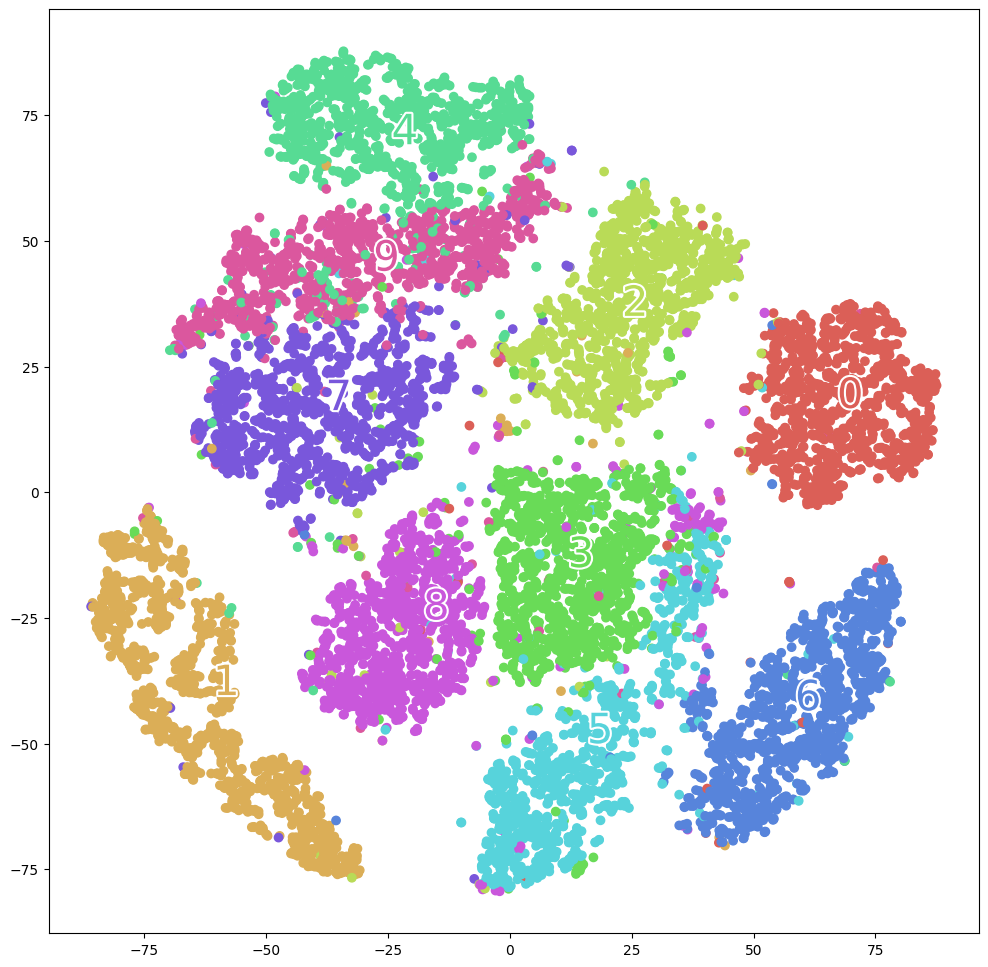

In [36]:
palette = np.array(sns.color_palette("hls", 10))
fig, ax = plt.subplots(figsize=(12, 12))
plt.scatter(ts[:,0], ts[:,1], c=palette[colors])
plt.axis('tight')

for i in range(10):
    labelx, labely = np.mean(ts[colors == i, :], axis=0)
    lbl = ax.text(labelx, labely, str(i), c=palette[i], fontsize=30)
    lbl.set_path_effects([
        PathEffects.Stroke(linewidth=3, foreground="w"),
        PathEffects.Normal()
    ])
plt.show()

## Conditional VAE 

In [37]:
class CVAE(nn.Module):
    def __init__(self):
        super().__init__()
        
        #encoder
        self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Linear(
                in_features=(1*28*28),
                out_features=256,
            ),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.25),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.25),
            nn.Linear(in_features=128, out_features=(32 * 2)),
        )
        self.decoder = nn.Sequential(
            nn.Linear(
                in_features=(32 + 10),
                out_features=128,
            ),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.25),
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.25),
            nn.Linear(
                in_features=256,
                out_features=(1 * 28 * 28),
            ),
            nn.Sigmoid(),
        )

    def encode(self, x):
        # (32, 128)
#         print(self.encoder(x).shape)
        flat = self.flatten(x)
        latent = self.encoder(flat).view(-1,2,32)
        
        mu = latent[:,0,:] # the first feature values as mean
        logsigma = latent[:,1,:] # the other feature values as variance
#         print('mu', mu.shape)
        return mu, logsigma
    
    def gaussian_sampler(self, mu, logsigma):
        if self.training:
            std = torch.exp(0.5 * logsigma) # standard deviation
            eps = torch.randn_like(std) # `randn_like` as we need the same size
            sample = mu + (eps * std) # sampling as if coming from the input space
            return sample
        else:
            return mu
    
    def decode(self, z):
        reconstruction = self.decoder(z).view(-1, 1, 28, 28)
        
        return reconstruction

    def forward(self, x, labels):
        mu, logsigma = self.encode(x)
        
#         print('mu', mu.shape)
        z = self.gaussian_sampler(mu, logsigma)
#         print(z.shape)
        
#         padding = torch.zeros(32,6).to(device)
        z_new = torch.cat((z, labels),1)
#         print(z_new.shape)
        reconstruction = self.decode(z_new)

        return mu, logsigma, reconstruction

In [38]:
from sklearn.preprocessing import OneHotEncoder

In [39]:
y_train = np.array([digit for _, digit in train_dataset])
y_test = np.array([digit for _, digit in test_dataset])

In [40]:
ohencoder = OneHotEncoder()
train_encoded = ohencoder.fit_transform(y_train.reshape(-1,1))
test_encoded = ohencoder.transform(y_test.reshape(-1,1))

In [41]:
train_labels = torch.FloatTensor(train_encoded.toarray()).to(device)
test_labels = torch.FloatTensor(test_encoded.toarray()).to(device)

In [42]:
train_ds = list(map(lambda x,y: (x,y),train_nums,train_labels))
test_ds = list(map(lambda x,y: (x,y),test_nums,test_labels))


train_loader = torch.utils.data.DataLoader(dataset=train_ds,
                                           batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_ds,
                                          batch_size=batch_size, shuffle=False)

In [43]:
criterion = VAELoss()

cvae = CVAE().to(device)

optimizer = torch.optim.Adam(cvae.parameters())

In [44]:
def train(model,optimizer,criterion,train_data,val_data, epochs = 70, device = torch.device('cpu')):
  val_data, val_labels = next(iter(val_data))
#   val_data, val_labels = torch.FloatTensor(val_data),torch.FloatTensor(val_labels)

  train_losses = []
  val_losses = []
  progress = tqdm(range(epochs), desc='Epoch')
  for epoch in progress:
    for batch in train_data:
      data = batch[0].to(device)
      labels = batch[1].to(device)
      model.train()
      optimizer.zero_grad()
      
      mu, logsigma, reconstruction = model(data.cuda(), labels.cuda())
#       print(reconstruction.shape)
      loss = criterion(data.cuda(), mu, logsigma, reconstruction)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      
    with torch.no_grad():
      model.eval()
      val_mu, val_logsigma, val_reconstruction = model(val_data.cuda(),val_labels.cuda())
      # val_imgs.append(reconstruction)
      loss = criterion(val_data.cuda(), val_mu, val_logsigma, val_reconstruction)
      # print(loss)
      val_losses.append(loss.cpu())
      
    print('\n',"train loss:", train_losses[-1].cpu().detach().numpy(),' valid loss:', val_losses[-1].cpu().detach().numpy())

  # return train_losses, val_losses

In [45]:
train(cvae, optimizer, criterion, train_loader, test_loader)

Epoch:   1%|▏         | 1/70 [00:09<10:54,  9.49s/it]


 train loss: 5355.788  valid loss: 3983.003


Epoch:   3%|▎         | 2/70 [00:17<09:47,  8.64s/it]


 train loss: 5196.521  valid loss: 3755.6064


Epoch:   4%|▍         | 3/70 [00:26<09:42,  8.69s/it]


 train loss: 5076.9  valid loss: 3610.0427


Epoch:   6%|▌         | 4/70 [00:35<09:38,  8.77s/it]


 train loss: 5013.062  valid loss: 3656.6528


Epoch:   7%|▋         | 5/70 [00:43<09:16,  8.56s/it]


 train loss: 5031.878  valid loss: 3585.0454


Epoch:   9%|▊         | 6/70 [00:52<09:12,  8.63s/it]


 train loss: 4974.429  valid loss: 3500.631


Epoch:  10%|█         | 7/70 [01:00<09:08,  8.71s/it]


 train loss: 5061.505  valid loss: 3591.6182


Epoch:  11%|█▏        | 8/70 [01:09<08:52,  8.58s/it]


 train loss: 4929.1953  valid loss: 3415.3496


Epoch:  13%|█▎        | 9/70 [01:18<08:45,  8.62s/it]


 train loss: 4866.517  valid loss: 3471.4624


Epoch:  14%|█▍        | 10/70 [01:26<08:41,  8.70s/it]


 train loss: 4930.0464  valid loss: 3410.792


Epoch:  16%|█▌        | 11/70 [01:35<08:33,  8.70s/it]


 train loss: 4959.322  valid loss: 3380.246


Epoch:  17%|█▋        | 12/70 [01:43<08:18,  8.60s/it]


 train loss: 4790.0854  valid loss: 3386.8943


Epoch:  19%|█▊        | 13/70 [01:52<08:13,  8.65s/it]


 train loss: 4924.875  valid loss: 3380.0737


Epoch:  20%|██        | 14/70 [02:01<08:06,  8.68s/it]


 train loss: 4893.6895  valid loss: 3387.1301


Epoch:  21%|██▏       | 15/70 [02:09<07:53,  8.60s/it]


 train loss: 4787.0757  valid loss: 3369.1135


Epoch:  23%|██▎       | 16/70 [02:18<07:50,  8.71s/it]


 train loss: 4829.8164  valid loss: 3362.5627


Epoch:  24%|██▍       | 17/70 [02:27<07:44,  8.77s/it]


 train loss: 4919.472  valid loss: 3341.0596


Epoch:  26%|██▌       | 18/70 [02:36<07:27,  8.61s/it]


 train loss: 4820.232  valid loss: 3362.1287


Epoch:  27%|██▋       | 19/70 [02:44<07:23,  8.70s/it]


 train loss: 4861.9253  valid loss: 3345.7993


Epoch:  29%|██▊       | 20/70 [02:53<07:14,  8.68s/it]


 train loss: 4776.7236  valid loss: 3350.1135


Epoch:  30%|███       | 21/70 [03:01<06:58,  8.54s/it]


 train loss: 4776.6177  valid loss: 3326.8533


Epoch:  31%|███▏      | 22/70 [03:10<06:48,  8.50s/it]


 train loss: 4939.153  valid loss: 3344.823


Epoch:  33%|███▎      | 23/70 [03:18<06:41,  8.53s/it]


 train loss: 4822.818  valid loss: 3324.7021


Epoch:  34%|███▍      | 24/70 [03:27<06:30,  8.48s/it]


 train loss: 4836.626  valid loss: 3329.4338


Epoch:  36%|███▌      | 25/70 [03:35<06:19,  8.43s/it]


 train loss: 4806.3228  valid loss: 3319.4895


Epoch:  37%|███▋      | 26/70 [03:44<06:15,  8.52s/it]


 train loss: 4854.273  valid loss: 3304.5083


Epoch:  39%|███▊      | 27/70 [03:52<06:06,  8.53s/it]


 train loss: 4820.4575  valid loss: 3338.0078


Epoch:  40%|████      | 28/70 [04:00<05:53,  8.42s/it]


 train loss: 4838.974  valid loss: 3318.2156


Epoch:  41%|████▏     | 29/70 [04:09<05:49,  8.52s/it]


 train loss: 4865.453  valid loss: 3312.151


Epoch:  43%|████▎     | 30/70 [04:18<05:41,  8.54s/it]


 train loss: 4897.173  valid loss: 3301.297


Epoch:  44%|████▍     | 31/70 [04:26<05:27,  8.40s/it]


 train loss: 4851.385  valid loss: 3313.1738


Epoch:  46%|████▌     | 32/70 [04:34<05:21,  8.45s/it]


 train loss: 4903.0234  valid loss: 3309.1775


Epoch:  47%|████▋     | 33/70 [04:43<05:15,  8.52s/it]


 train loss: 4775.868  valid loss: 3326.0137


Epoch:  49%|████▊     | 34/70 [04:51<05:01,  8.38s/it]


 train loss: 4837.1953  valid loss: 3308.2295


Epoch:  50%|█████     | 35/70 [05:00<04:56,  8.48s/it]


 train loss: 4777.274  valid loss: 3298.2573


Epoch:  51%|█████▏    | 36/70 [05:08<04:50,  8.53s/it]


 train loss: 4861.761  valid loss: 3295.8923


Epoch:  53%|█████▎    | 37/70 [05:17<04:36,  8.39s/it]


 train loss: 4857.7437  valid loss: 3297.0508


Epoch:  54%|█████▍    | 38/70 [05:25<04:30,  8.47s/it]


 train loss: 4752.92  valid loss: 3284.641


Epoch:  56%|█████▌    | 39/70 [05:34<04:24,  8.54s/it]


 train loss: 4802.919  valid loss: 3290.567


Epoch:  57%|█████▋    | 40/70 [05:42<04:13,  8.45s/it]


 train loss: 4829.161  valid loss: 3312.789


Epoch:  59%|█████▊    | 41/70 [05:51<04:04,  8.44s/it]


 train loss: 4732.1475  valid loss: 3305.431


Epoch:  60%|██████    | 42/70 [05:59<03:57,  8.48s/it]


 train loss: 4909.5776  valid loss: 3325.3164


Epoch:  61%|██████▏   | 43/70 [06:08<03:48,  8.47s/it]


 train loss: 4815.759  valid loss: 3308.6208


Epoch:  63%|██████▎   | 44/70 [06:16<03:39,  8.44s/it]


 train loss: 4754.7676  valid loss: 3310.2725


Epoch:  64%|██████▍   | 45/70 [06:25<03:33,  8.55s/it]


 train loss: 4777.6895  valid loss: 3299.2793


Epoch:  66%|██████▌   | 46/70 [06:33<03:26,  8.60s/it]


 train loss: 4812.5757  valid loss: 3317.5762


Epoch:  67%|██████▋   | 47/70 [06:42<03:14,  8.45s/it]


 train loss: 4686.754  valid loss: 3288.7969


Epoch:  69%|██████▊   | 48/70 [06:50<03:07,  8.53s/it]


 train loss: 4877.9985  valid loss: 3304.5273


Epoch:  70%|███████   | 49/70 [06:59<03:00,  8.58s/it]


 train loss: 4816.5522  valid loss: 3283.263


Epoch:  71%|███████▏  | 50/70 [07:07<02:48,  8.42s/it]


 train loss: 4696.853  valid loss: 3295.9346


Epoch:  73%|███████▎  | 51/70 [07:16<02:41,  8.48s/it]


 train loss: 4826.696  valid loss: 3277.3848


Epoch:  74%|███████▍  | 52/70 [07:24<02:34,  8.57s/it]


 train loss: 4782.0596  valid loss: 3314.5496


Epoch:  76%|███████▌  | 53/70 [07:33<02:23,  8.43s/it]


 train loss: 4740.5674  valid loss: 3298.396


Epoch:  77%|███████▋  | 54/70 [07:41<02:16,  8.52s/it]


 train loss: 4846.227  valid loss: 3270.5325


Epoch:  79%|███████▊  | 55/70 [07:50<02:08,  8.58s/it]


 train loss: 4773.6494  valid loss: 3289.3345


Epoch:  80%|████████  | 56/70 [07:58<01:58,  8.44s/it]


 train loss: 4841.608  valid loss: 3280.0825


Epoch:  81%|████████▏ | 57/70 [08:07<01:50,  8.48s/it]


 train loss: 4955.0757  valid loss: 3306.6895


Epoch:  83%|████████▎ | 58/70 [08:15<01:42,  8.52s/it]


 train loss: 4838.7935  valid loss: 3282.0098


Epoch:  84%|████████▍ | 59/70 [08:24<01:32,  8.44s/it]


 train loss: 4838.7896  valid loss: 3293.149


Epoch:  86%|████████▌ | 60/70 [08:32<01:23,  8.39s/it]


 train loss: 4812.629  valid loss: 3270.2676


Epoch:  87%|████████▋ | 61/70 [08:40<01:16,  8.48s/it]


 train loss: 4748.6206  valid loss: 3291.9343


Epoch:  89%|████████▊ | 62/70 [08:49<01:08,  8.51s/it]


 train loss: 4931.5044  valid loss: 3307.4026


Epoch:  90%|█████████ | 63/70 [08:57<00:58,  8.42s/it]


 train loss: 4774.8345  valid loss: 3286.7705


Epoch:  91%|█████████▏| 64/70 [09:06<00:51,  8.53s/it]


 train loss: 4807.1504  valid loss: 3278.4075


Epoch:  93%|█████████▎| 65/70 [09:15<00:43,  8.61s/it]


 train loss: 4843.7485  valid loss: 3272.9465


Epoch:  94%|█████████▍| 66/70 [09:23<00:33,  8.48s/it]


 train loss: 4835.484  valid loss: 3280.573


Epoch:  96%|█████████▌| 67/70 [09:32<00:26,  8.68s/it]


 train loss: 4792.4355  valid loss: 3304.7222


Epoch:  97%|█████████▋| 68/70 [09:41<00:17,  8.69s/it]


 train loss: 4763.1274  valid loss: 3255.9548


Epoch:  99%|█████████▊| 69/70 [09:49<00:08,  8.48s/it]


 train loss: 4806.011  valid loss: 3270.906


Epoch: 100%|██████████| 70/70 [09:58<00:00,  8.54s/it]


 train loss: 4774.297  valid loss: 3285.9443


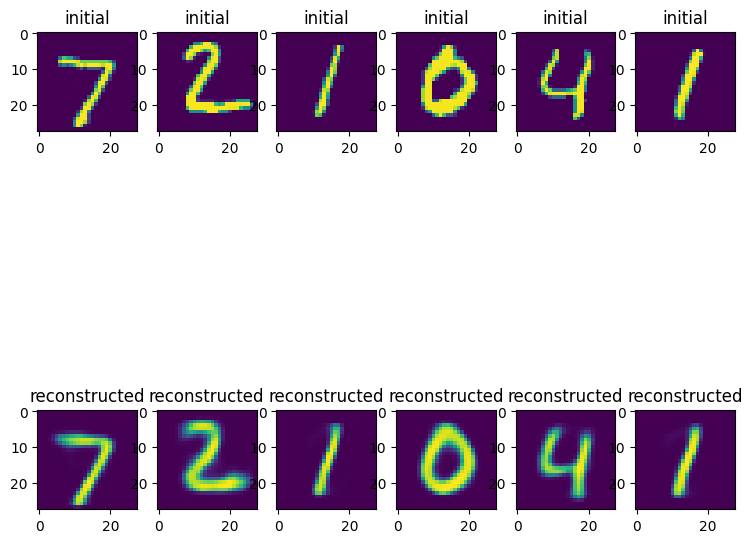

In [46]:
fig = plt.figure(figsize=(9, 9))
axes = fig.subplots(nrows=2, ncols=6)

data, labels = next(iter(test_loader))
_,_,reconstructions= cvae(data.to(device), labels.to(device))

for i in range(len(test_nums[:6])):
  axes[0, i].imshow(test_nums[i].cpu().numpy().transpose(1,2,0))
  axes[0, i].set_title('initial')

  img_recon = reconstructions[i] 
  axes[1, i].imshow(img_recon.cpu().detach().numpy().transpose(1,2,0))
  axes[1, i].set_title('reconstructed')

In [47]:
sample5_data = []
for ind, i in enumerate(y_train):
    if i == 5:
        sample5_data.append(train_ds[ind])

sample5_loader = torch.utils.data.DataLoader(dataset = sample5_data, batch_size = 32, shuffle = False)

sample7_data = []
for ind, i in enumerate(y_train):
    if i == 7:
        sample7_data.append(train_ds[ind])

sample7_loader = torch.utils.data.DataLoader(dataset = sample7_data, batch_size = 32, shuffle = False)

In [48]:
latents5 = torch.Tensor()
for batch in sample5_loader:
    data = batch[0].to(device)
    labels = batch[1].to(device)
    cvae.eval()
    with torch.no_grad():
        mu, logsigma = cvae.encode(data)
        z = cvae.gaussian_sampler(mu, logsigma)
        z_new = torch.cat((z, labels), 1)
        latents5 = torch.cat((latents5.cpu(), z_new.cpu()))

lat_mean5 = latents5.mean(dim=0)
lat_std5 = latents5.std(dim=0)

latents7 = torch.Tensor()
for batch in sample7_loader:
    data = batch[0].to(device)
    labels = batch[1].to(device)
    cvae.eval()
    with torch.no_grad():
        mu, logsigma = cvae.encode(data)
        z = cvae.gaussian_sampler(mu, logsigma)
        z_new = torch.cat((z, labels), 1)
        latents7 = torch.cat((latents7.cpu(), z_new.cpu()))

lat_mean7 = latents7.mean(dim=0)
lat_std7 = latents7.std(dim=0)

In [49]:
z = torch.FloatTensor([np.random.normal(0, 1, 42) for i in range(10)])
z5 = z * lat_std5 + lat_mean5
z7 = z * lat_std7 + lat_mean7

cvae.eval()
with torch.no_grad():
    sample5 = cvae.decode(z5.to(device))
    sample7 = cvae.decode(z7.to(device))
sample5 = sample5.cpu().detach()
sample7 = sample7.cpu().detach()

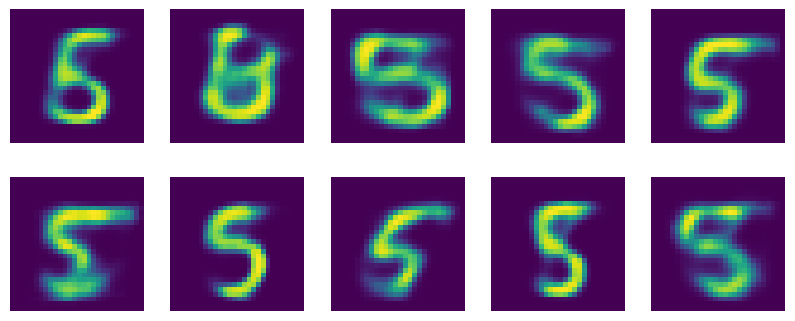

In [50]:
rows, cols = (2, 5)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
for ax, img in zip(axes.flatten(), sample5):
    ax.axis('off')
    ax.imshow(img.numpy().transpose(1, 2, 0))

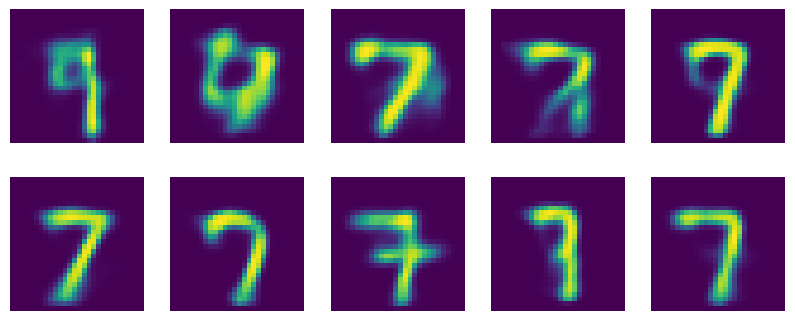

In [51]:
rows, cols = (2, 5)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
for ax, img in zip(axes.flatten(), sample7):
    ax.axis('off')
    ax.imshow(img.numpy().transpose(1, 2, 0))

In [52]:
latents = torch.Tensor()
for inputs in tqdm(train_loader):
    inputs = inputs[0].to(device)
    with torch.no_grad():
        mu, logsigma = cvae.encode(inputs)
        z = cvae.gaussian_sampler(mu, logsigma)
        latents = torch.cat((latents.cpu(), z.cpu()))

100%|██████████| 1875/1875 [00:02<00:00, 839.26it/s]


In [53]:
x = latents[::5].numpy()
colors = np.array([color for _, color in train_dataset])[::5]

ts = TSNE(random_state=42, verbose=2).fit_transform(x)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 12000 samples in 0.001s...
[t-SNE] Computed neighbors for 12000 samples in 1.994s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12000
[t-SNE] Computed conditional probabilities for sample 2000 / 12000
[t-SNE] Computed conditional probabilities for sample 3000 / 12000
[t-SNE] Computed conditional probabilities for sample 4000 / 12000
[t-SNE] Computed conditional probabilities for sample 5000 / 12000
[t-SNE] Computed conditional probabilities for sample 6000 / 12000
[t-SNE] Computed conditional probabilities for sample 7000 / 12000
[t-SNE] Computed conditional probabilities for sample 8000 / 12000
[t-SNE] Computed conditional probabilities for sample 9000 / 12000
[t-SNE] Computed conditional probabilities for sample 10000 / 12000
[t-SNE] Computed conditional probabilities for sample 11000 / 12000
[t-SNE] Computed conditional probabilities for sample 12000 / 12000
[t-SNE] Mean sigma: 0.903945
[t-SNE] Computed cond

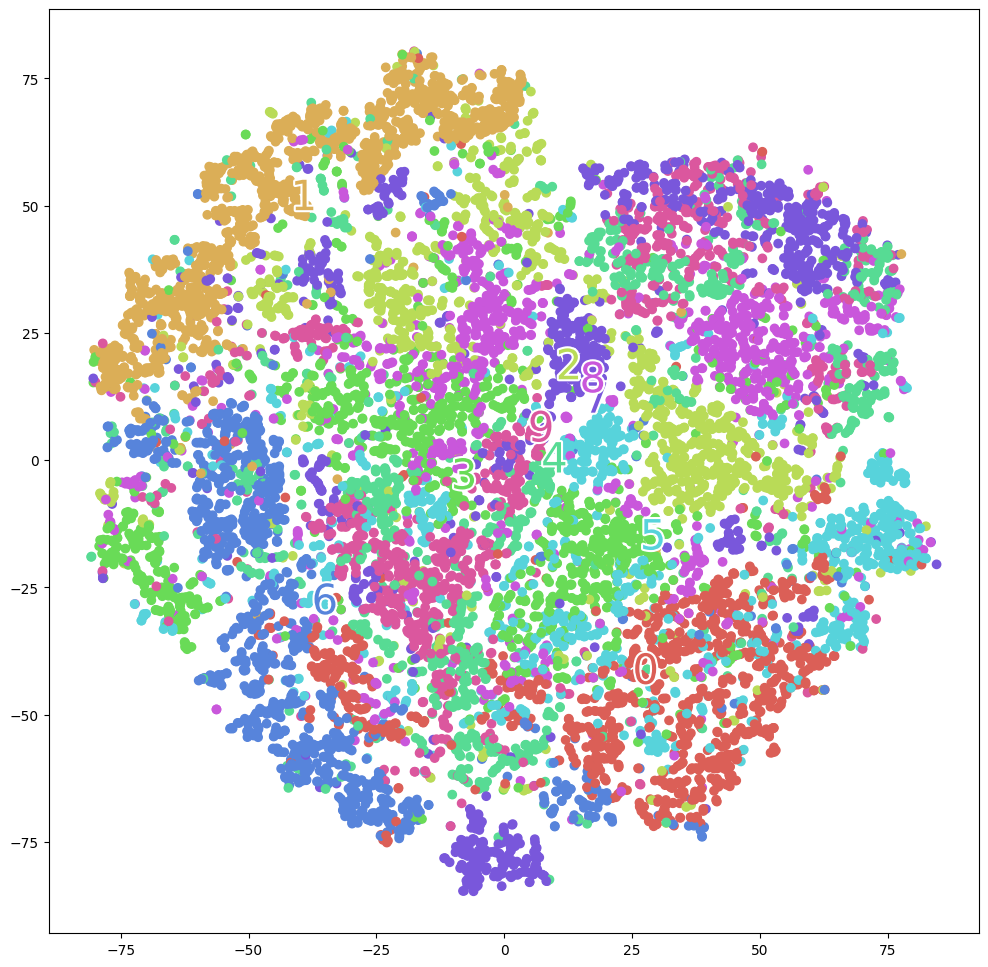

In [54]:
palette = np.array(sns.color_palette("hls", 10))
fig, ax = plt.subplots(figsize=(12, 12))
plt.scatter(ts[:,0], ts[:,1], c=palette[colors])
plt.axis('tight')

for i in range(10):
    labelx, labely = np.mean(ts[colors == i, :], axis=0)
    lbl = ax.text(labelx, labely, str(i), c=palette[i], fontsize=30)
    lbl.set_path_effects([
        PathEffects.Stroke(linewidth=3, foreground="w"),
        PathEffects.Normal()
    ])
plt.show()